## Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## データセットの準備

In [ ]:
# kaggle ライブラリのインストール
!pip install kaggle

# 一時フォルダに .kaggleフォルダを作成
!mkdir ~/.kaggle

# MyDrive の kaggle.json を一時フォルダ内の .kaggleフォルダにコピー
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

!mkdir ~/.kaggle

# zipファイルのダウンロード
!kaggle datasets download -d ashaheedq/video-games-sales-2019 -p /content/drive/MyDrive/kaggle

# 解凍
!unzip /content/drive/MyDrive/kaggle/video-games-sales-2019.zip -d /content/drive/MyDrive/kaggle

!rm /content/drive/MyDrive/kaggle/video-games-sales-2019.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/3.98M [00:00<?, ?B/s]
100% 3.98M/3.98M [00:00<00:00, 65.3MB/s]
Archive:  /content/drive/MyDrive/kaggle/video-games-sales-2019.zip
replace /content/drive/MyDrive/kaggle/vgsales-12-4-2019-short.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


## データの読込

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/kaggle/vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,NaN,82.86,NaN,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,NaN,40.24,NaN,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,9.1,37.14,NaN,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


## ベイズ最適化

In [ ]:
!pip install category_encoders
!pip install bayesian-optimization
!pip install optuna
!pip install pandas

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
from natsort import natsorted 
import time
import lightgbm as lgb
import optuna.integration.lightgbm as opt_lgb
from sklearn.model_selection import GroupKFold
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from bayes_opt import BayesianOptimization

import warnings
warnings.simplefilter('ignore')

In [ ]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED
                                                    ) 

In [ ]:
### 欠損値補完
X_train_ff = X_train.fillna(method='ffill')
X_test_ff = X_test.fillna(method='ffill')

#### カテゴリーエンコーディング

# ユニーク数に応じてカラムを分割する
category_unique_num = X_train_ff.select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index


# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train_ff[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)


# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データをコピー
X_train_ce = X_train_ff.copy()
X_test_ce = X_test_ff.copy()

# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )

### optuna.integration.lightgbm によるハイパーパラメーター調整実施

[I 2021-12-10 12:05:00,458] A new study created in memory with name: no-name-a0179bce-4052-45aa-bdcf-b3b25aa44c42
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.345643:  14%|#4        | 1/7 [00:00<00:03,  1.90it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.142844	Test's rmse: 0.345643
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.345643:  29%|##8       | 2/7 [00:00<00:02,  2.35it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121108	Test's rmse: 0.35739
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.345643:  43%|####2     | 3/7 [00:01<00:01,  2.40it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.116552	Test's rmse: 0.357411
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.340763:  57%|#####7    | 4/7 [00:01<00:01,  2.28it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.108445	Test's rmse: 0.340763
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.340763:  71%|#######1  | 5/7 [00:02<00:00,  2.29it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.108089	Test's rmse: 0.364121
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.340763:  86%|########5 | 6/7 [00:02<00:00,  2.22it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.104324	Test's rmse: 0.352257
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.340763: 100%|##########| 7/7 [00:03<00:00,  2.20it/s]


Early stopping, best iteration is:
[46]	Train's rmse: 0.145024	Test's rmse: 0.345074


num_leaves, val_score: 0.340763:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.340763:   5%|5         | 1/20 [00:01<00:24,  1.29s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.11313	Test's rmse: 0.347397
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.340763:  10%|#         | 2/20 [00:02<00:26,  1.49s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112961	Test's rmse: 0.346638
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.340763:  15%|#5        | 3/20 [00:03<00:20,  1.19s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.109684	Test's rmse: 0.344173
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.340763:  20%|##        | 4/20 [00:04<00:18,  1.17s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.107691	Test's rmse: 0.347154
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.340763:  25%|##5       | 5/20 [00:05<00:14,  1.03it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.107261	Test's rmse: 0.344993
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.340763:  30%|###       | 6/20 [00:06<00:13,  1.07it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.108574	Test's rmse: 0.348775
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.340763:  35%|###5      | 7/20 [00:07<00:11,  1.09it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.109121	Test's rmse: 0.35008
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.340763:  40%|####      | 8/20 [00:08<00:13,  1.09s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112019	Test's rmse: 0.347304
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.327161:  45%|####5     | 9/20 [00:08<00:08,  1.24it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174053	Test's rmse: 0.327161
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.327161:  50%|#####     | 10/20 [00:10<00:09,  1.08it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.107687	Test's rmse: 0.348799
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.327161:  55%|#####5    | 11/20 [00:10<00:06,  1.41it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140733	Test's rmse: 0.333048
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.327161:  60%|######    | 12/20 [00:10<00:04,  1.72it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112481	Test's rmse: 0.350009
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.327161:  65%|######5   | 13/20 [00:10<00:03,  2.12it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12525	Test's rmse: 0.343035
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.327161:  70%|#######   | 14/20 [00:11<00:02,  2.04it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.105544	Test's rmse: 0.347965
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.327161:  75%|#######5  | 15/20 [00:13<00:04,  1.13it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.114768	Test's rmse: 0.348172
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.327161:  80%|########  | 16/20 [00:13<00:03,  1.26it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.110571	Test's rmse: 0.345503
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174053	Test's rmse: 0.327161


num_leaves, val_score: 0.327161:  85%|########5 | 17/20 [00:13<00:01,  1.64it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.327161:  90%|######### | 18/20 [00:14<00:01,  1.75it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.108467	Test's rmse: 0.341726
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.327161:  95%|#########5| 19/20 [00:15<00:00,  1.62it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.109634	Test's rmse: 0.344611
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.327161: 100%|##########| 20/20 [00:16<00:00,  1.24it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111989	Test's rmse: 0.346356


bagging, val_score: 0.327161:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.327161:  10%|#         | 1/10 [00:00<00:01,  5.54it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173041	Test's rmse: 0.329836
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.327161:  30%|###       | 3/10 [00:00<00:01,  5.28it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169882	Test's rmse: 0.330764
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173475	Test's rmse: 0.328374


bagging, val_score: 0.327161:  40%|####      | 4/10 [00:00<00:01,  5.31it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170074	Test's rmse: 0.333749
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.325747:  60%|######    | 6/10 [00:01<00:00,  5.58it/s]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.173455	Test's rmse: 0.325747
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173889	Test's rmse: 0.332579


bagging, val_score: 0.325747:  70%|#######   | 7/10 [00:01<00:00,  5.39it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169029	Test's rmse: 0.328484
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.323839:  90%|######### | 9/10 [00:01<00:00,  5.33it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172516	Test's rmse: 0.323839
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170218	Test's rmse: 0.33135


[I 2021-12-10 12:05:21,509] Trial 35 finished with value: 0.331349808105967 and parameters: {'bagging_fraction': 0.7489985082995396, 'bagging_freq': 3}. Best is trial 34 with value: 0.32383901424089667.
bagging, val_score: 0.323839: 100%|##########| 10/10 [00:01<00:00,  5.33it/s]


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170422	Test's rmse: 0.326515


feature_fraction_stage2, val_score: 0.323839:  17%|#6        | 1/6 [00:00<00:00,  5.79it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173266	Test's rmse: 0.325034
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.323839:  50%|#####     | 3/6 [00:00<00:00,  5.51it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17385	Test's rmse: 0.328827
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174406	Test's rmse: 0.327976


[I 2021-12-10 12:05:22,264] Trial 39 finished with value: 0.3279763309626427 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 0.3250338541831725.
feature_fraction_stage2, val_score: 0.323839:  67%|######6   | 4/6 [00:00<00:00,  5.59it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172516	Test's rmse: 0.323839
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.323839: 100%|##########| 6/6 [00:01<00:00,  5.56it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172516	Test's rmse: 0.323839
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174406	Test's rmse: 0.327976


regularization_factors, val_score: 0.323839:   5%|5         | 1/20 [00:00<00:03,  5.57it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172516	Test's rmse: 0.323839
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.323839:  15%|#5        | 3/20 [00:00<00:03,  5.37it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172516	Test's rmse: 0.323839
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172516	Test's rmse: 0.323839


[I 2021-12-10 12:05:23,365] Trial 45 finished with value: 0.3238390088653721 and parameters: {'lambda_l1': 0.00011364463485096112, 'lambda_l2': 0.00037077020564552565}. Best is trial 43 with value: 0.32383900870569265.
regularization_factors, val_score: 0.323839:  20%|##        | 4/20 [00:00<00:03,  5.33it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172516	Test's rmse: 0.323839
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.323839:  30%|###       | 6/20 [00:01<00:02,  5.33it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172521	Test's rmse: 0.323842
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172516	Test's rmse: 0.323839


regularization_factors, val_score: 0.323839:  35%|###5      | 7/20 [00:01<00:02,  5.38it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172516	Test's rmse: 0.323839
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.323839:  45%|####5     | 9/20 [00:01<00:02,  5.32it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17255	Test's rmse: 0.32386
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172516	Test's rmse: 0.323839


regularization_factors, val_score: 0.323839:  50%|#####     | 10/20 [00:01<00:01,  5.40it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172516	Test's rmse: 0.323839
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.323839:  60%|######    | 12/20 [00:02<00:01,  5.33it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174831	Test's rmse: 0.330198
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.174347	Test's rmse: 0.326891


regularization_factors, val_score: 0.323838:  65%|######5   | 13/20 [00:02<00:01,  5.14it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172518	Test's rmse: 0.323838


regularization_factors, val_score: 0.323838:  70%|#######   | 14/20 [00:02<00:01,  5.19it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173092	Test's rmse: 0.327953
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.323838:  75%|#######5  | 15/20 [00:02<00:00,  5.23it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172517	Test's rmse: 0.323838
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.323837:  85%|########5 | 17/20 [00:03<00:00,  5.16it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172518	Test's rmse: 0.323837
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172517	Test's rmse: 0.323838


[I 2021-12-10 12:05:26,043] Trial 59 finished with value: 0.32383812814168544 and parameters: {'lambda_l1': 1.613433682511789e-08, 'lambda_l2': 0.009979837516815087}. Best is trial 58 with value: 0.3238374653483406.
regularization_factors, val_score: 0.323837:  90%|######### | 18/20 [00:03<00:00,  5.23it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172518	Test's rmse: 0.323837
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.323837: 100%|##########| 20/20 [00:03<00:00,  5.24it/s]

Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.174371	Test's rmse: 0.326947
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17306	Test's rmse: 0.325375


[I 2021-12-10 12:05:26,614] Trial 62 finished with value: 0.3253753690563886 and parameters: {'lambda_l1': 2.340540676000211e-06, 'lambda_l2': 4.737933404470059}. Best is trial 60 with value: 0.3238369546543461.
min_data_in_leaf, val_score: 0.323837:  20%|##        | 1/5 [00:00<00:00,  5.68it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148529	Test's rmse: 0.336504
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.323837:  60%|######    | 3/5 [00:00<00:00,  5.52it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156076	Test's rmse: 0.329743
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173186	Test's rmse: 0.328716


min_data_in_leaf, val_score: 0.323837:  80%|########  | 4/5 [00:00<00:00,  5.44it/s]

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.23171	Test's rmse: 0.380433
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.323837: 100%|##########| 5/5 [00:00<00:00,  5.40it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.293306	Test's rmse: 0.445557


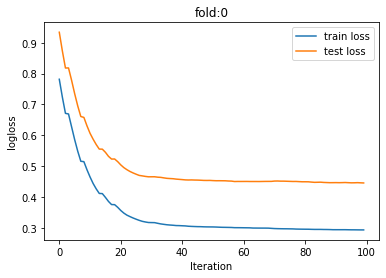

[I 2021-12-10 12:05:27,784] A new study created in memory with name: no-name-6819e9b1-4952-48a7-b899-759d541683ab
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.107196:  14%|#4        | 1/7 [00:00<00:02,  2.13it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131381	Test's rmse: 0.107196
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.107196:  29%|##8       | 2/7 [00:00<00:02,  2.35it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133052	Test's rmse: 0.136101
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.107196:  43%|####2     | 3/7 [00:01<00:01,  2.17it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148628	Test's rmse: 0.111997
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.107196:  57%|#####7    | 4/7 [00:01<00:01,  2.12it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146464	Test's rmse: 0.11008
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.107196:  71%|#######1  | 5/7 [00:02<00:00,  2.34it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140926	Test's rmse: 0.139514
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.107196:  86%|########5 | 6/7 [00:02<00:00,  2.27it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128728	Test's rmse: 0.109712
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.107196: 100%|##########| 7/7 [00:03<00:00,  2.26it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131213	Test's rmse: 0.124715


num_leaves, val_score: 0.107196:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.107196:   5%|5         | 1/20 [00:00<00:17,  1.08it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135652	Test's rmse: 0.111941
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.107196:  10%|#         | 2/20 [00:02<00:23,  1.29s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129382	Test's rmse: 0.112883
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.107196:  15%|#5        | 3/20 [00:03<00:21,  1.26s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128421	Test's rmse: 0.118125
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.107196:  20%|##        | 4/20 [00:05<00:22,  1.39s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136665	Test's rmse: 0.115736
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.107196:  25%|##5       | 5/20 [00:05<00:17,  1.14s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13064	Test's rmse: 0.112652
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.107196:  30%|###       | 6/20 [00:06<00:13,  1.00it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13064	Test's rmse: 0.112652
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.106676:  35%|###5      | 7/20 [00:07<00:10,  1.19it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131066	Test's rmse: 0.106676
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.106676:  40%|####      | 8/20 [00:08<00:13,  1.11s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136528	Test's rmse: 0.115203
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.106676:  45%|####5     | 9/20 [00:10<00:14,  1.34s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136922	Test's rmse: 0.117474
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.106676:  50%|#####     | 10/20 [00:12<00:13,  1.35s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13102	Test's rmse: 0.113326
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.106676:  55%|#####5    | 11/20 [00:12<00:09,  1.01s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137528	Test's rmse: 0.109558
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.106676:  60%|######    | 12/20 [00:12<00:06,  1.28it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133801	Test's rmse: 0.113082
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.106676:  65%|######5   | 13/20 [00:12<00:04,  1.65it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.180307	Test's rmse: 0.116277
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.106676:  70%|#######   | 14/20 [00:13<00:03,  1.66it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127994	Test's rmse: 0.111443
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.101216:  75%|#######5  | 15/20 [00:13<00:02,  1.74it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131004	Test's rmse: 0.101216
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.101216:  80%|########  | 16/20 [00:14<00:02,  1.43it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129507	Test's rmse: 0.112135
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.101216:  85%|########5 | 17/20 [00:15<00:01,  1.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12741	Test's rmse: 0.108935
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.101216:  90%|######### | 18/20 [00:16<00:01,  1.32it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130478	Test's rmse: 0.107048
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.101216:  95%|#########5| 19/20 [00:17<00:00,  1.44it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130188	Test's rmse: 0.106763
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.101216: 100%|##########| 20/20 [00:18<00:00,  1.09it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129581	Test's rmse: 0.11505


bagging, val_score: 0.101216:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.101216:  10%|#         | 1/10 [00:00<00:04,  1.96it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.157226	Test's rmse: 0.113766
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.101216:  20%|##        | 2/10 [00:01<00:04,  1.85it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161627	Test's rmse: 0.115857
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.101216:  30%|###       | 3/10 [00:01<00:03,  1.87it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173792	Test's rmse: 0.114981
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.101216:  40%|####      | 4/10 [00:02<00:03,  1.90it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132901	Test's rmse: 0.113588
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.101216:  50%|#####     | 5/10 [00:02<00:02,  1.91it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1585	Test's rmse: 0.115846
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.101216:  60%|######    | 6/10 [00:03<00:02,  1.88it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144787	Test's rmse: 0.110667
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.101216:  70%|#######   | 7/10 [00:03<00:01,  1.84it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140844	Test's rmse: 0.109628
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.101216:  80%|########  | 8/10 [00:04<00:01,  1.83it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17064	Test's rmse: 0.123243
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.101216:  90%|######### | 9/10 [00:04<00:00,  1.82it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172749	Test's rmse: 0.121803
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.101216: 100%|##########| 10/10 [00:05<00:00,  1.86it/s]


Early stopping, best iteration is:
[44]	Train's rmse: 0.203509	Test's rmse: 0.114285


feature_fraction_stage2, val_score: 0.101216:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.101216:  17%|#6        | 1/6 [00:00<00:02,  2.13it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128516	Test's rmse: 0.111119
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.101216:  33%|###3      | 2/6 [00:00<00:01,  2.11it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128475	Test's rmse: 0.102592
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.101216:  50%|#####     | 3/6 [00:01<00:01,  1.98it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133595	Test's rmse: 0.102481
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.101216:  67%|######6   | 4/6 [00:02<00:01,  1.97it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131004	Test's rmse: 0.101216
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.101216:  83%|########3 | 5/6 [00:02<00:00,  1.96it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131004	Test's rmse: 0.101216
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.101216: 100%|##########| 6/6 [00:03<00:00,  2.00it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128475	Test's rmse: 0.102592


regularization_factors, val_score: 0.101216:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101216:   5%|5         | 1/20 [00:00<00:10,  1.89it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131004	Test's rmse: 0.101216
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101216:  10%|#         | 2/20 [00:01<00:09,  1.96it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131443	Test's rmse: 0.106438
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101216:  15%|#5        | 3/20 [00:01<00:08,  1.91it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131004	Test's rmse: 0.101216
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101216:  20%|##        | 4/20 [00:02<00:08,  1.93it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131829	Test's rmse: 0.106839
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101216:  25%|##5       | 5/20 [00:02<00:07,  1.96it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132247	Test's rmse: 0.111543
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101216:  30%|###       | 6/20 [00:03<00:07,  1.97it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131826	Test's rmse: 0.106839
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101216:  35%|###5      | 7/20 [00:03<00:06,  1.97it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130477	Test's rmse: 0.109086
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101216:  40%|####      | 8/20 [00:04<00:06,  1.96it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132529	Test's rmse: 0.104455
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101216:  45%|####5     | 9/20 [00:04<00:05,  1.97it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131004	Test's rmse: 0.101216
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101216:  50%|#####     | 10/20 [00:05<00:05,  1.98it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130428	Test's rmse: 0.105925
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101216:  55%|#####5    | 11/20 [00:05<00:04,  2.03it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125671	Test's rmse: 0.112201
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101216:  60%|######    | 12/20 [00:06<00:03,  2.04it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131004	Test's rmse: 0.101216
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101216:  65%|######5   | 13/20 [00:06<00:03,  2.00it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131004	Test's rmse: 0.101217
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101216:  70%|#######   | 14/20 [00:07<00:02,  2.00it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131004	Test's rmse: 0.101216
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101216:  75%|#######5  | 15/20 [00:07<00:02,  1.99it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131004	Test's rmse: 0.101216
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101216:  80%|########  | 16/20 [00:08<00:01,  2.03it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130979	Test's rmse: 0.106289
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101216:  85%|########5 | 17/20 [00:08<00:01,  2.02it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131004	Test's rmse: 0.101216
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101216:  90%|######### | 18/20 [00:09<00:00,  2.04it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138919	Test's rmse: 0.11178
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101216:  95%|#########5| 19/20 [00:09<00:00,  2.01it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131004	Test's rmse: 0.101216
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.101216: 100%|##########| 20/20 [00:10<00:00,  1.99it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131004	Test's rmse: 0.101216


min_data_in_leaf, val_score: 0.101216:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.101216:  20%|##        | 1/5 [00:00<00:02,  1.92it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0670687	Test's rmse: 0.103614
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.101216:  40%|####      | 2/5 [00:01<00:01,  1.98it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.240705	Test's rmse: 0.188543
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.101216:  60%|######    | 3/5 [00:01<00:00,  2.05it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.0668818	Test's rmse: 0.126261
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.101216:  80%|########  | 4/5 [00:01<00:00,  2.03it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153887	Test's rmse: 0.119415
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.101216: 100%|##########| 5/5 [00:02<00:00,  2.10it/s]

Early stopping, best iteration is:
[24]	Train's rmse: 0.337483	Test's rmse: 0.228964


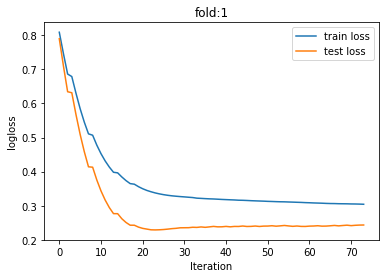

[I 2021-12-10 12:06:10,317] A new study created in memory with name: no-name-8b0ba9b7-36dd-4a5a-96dd-47eef1bef52d
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.174646:  14%|#4        | 1/7 [00:00<00:02,  2.83it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140306	Test's rmse: 0.174646
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.142317:  29%|##8       | 2/7 [00:00<00:02,  2.47it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124599	Test's rmse: 0.142317
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.139256:  43%|####2     | 3/7 [00:01<00:01,  2.28it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.139256:  57%|#####7    | 4/7 [00:01<00:01,  2.15it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141856	Test's rmse: 0.139473
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.139256:  71%|#######1  | 5/7 [00:02<00:00,  2.27it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130492	Test's rmse: 0.161674
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.139256:  86%|########5 | 6/7 [00:02<00:00,  2.17it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146988	Test's rmse: 0.141503
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.139256: 100%|##########| 7/7 [00:03<00:00,  2.25it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123915	Test's rmse: 0.144274


num_leaves, val_score: 0.139256:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:   5%|5         | 1/20 [00:01<00:36,  1.90s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133348	Test's rmse: 0.147992
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  10%|#         | 2/20 [00:02<00:19,  1.10s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131786	Test's rmse: 0.142499
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  15%|#5        | 3/20 [00:02<00:13,  1.28it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.122883	Test's rmse: 0.140504
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  20%|##        | 4/20 [00:04<00:17,  1.11s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135542	Test's rmse: 0.147668
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  25%|##5       | 5/20 [00:05<00:17,  1.17s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13936	Test's rmse: 0.147764
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  30%|###       | 6/20 [00:06<00:13,  1.04it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124171	Test's rmse: 0.139492
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  35%|###5      | 7/20 [00:07<00:14,  1.09s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134666	Test's rmse: 0.147121
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  40%|####      | 8/20 [00:08<00:10,  1.14it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129964	Test's rmse: 0.140187
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  45%|####5     | 9/20 [00:08<00:09,  1.18it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132801	Test's rmse: 0.143988
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  50%|#####     | 10/20 [00:10<00:10,  1.08s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135542	Test's rmse: 0.147668
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  55%|#####5    | 11/20 [00:11<00:09,  1.03s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13121	Test's rmse: 0.144524
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  60%|######    | 12/20 [00:12<00:07,  1.04it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134335	Test's rmse: 0.142115
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  65%|######5   | 13/20 [00:12<00:05,  1.36it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15729	Test's rmse: 0.151499
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  70%|#######   | 14/20 [00:13<00:04,  1.43it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133433	Test's rmse: 0.143754
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  75%|#######5  | 15/20 [00:14<00:04,  1.24it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136562	Test's rmse: 0.146123
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.210938	Test's rmse: 0.166323


num_leaves, val_score: 0.139256:  80%|########  | 16/20 [00:14<00:02,  1.64it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  85%|########5 | 17/20 [00:14<00:01,  1.63it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133433	Test's rmse: 0.143754
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  90%|######### | 18/20 [00:15<00:01,  1.37it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135066	Test's rmse: 0.147109
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256:  95%|#########5| 19/20 [00:16<00:00,  1.50it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132327	Test's rmse: 0.142061
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.139256: 100%|##########| 20/20 [00:17<00:00,  1.13it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136243	Test's rmse: 0.145501


bagging, val_score: 0.139256:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.139256:  10%|#         | 1/10 [00:00<00:05,  1.76it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135035	Test's rmse: 0.144351
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.139256:  20%|##        | 2/10 [00:01<00:04,  1.82it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170418	Test's rmse: 0.151502
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.139256:  30%|###       | 3/10 [00:01<00:03,  1.80it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134628	Test's rmse: 0.144431
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.139256:  40%|####      | 4/10 [00:02<00:03,  1.79it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130621	Test's rmse: 0.148383
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.139256:  50%|#####     | 5/10 [00:02<00:02,  1.79it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139057	Test's rmse: 0.146055
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.139256:  60%|######    | 6/10 [00:03<00:02,  1.80it/s]

Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.162026	Test's rmse: 0.161291
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.139256:  70%|#######   | 7/10 [00:03<00:01,  1.80it/s]

Did not meet early stopping. Best iteration is:
[96]	Train's rmse: 0.168738	Test's rmse: 0.155844
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.139256:  80%|########  | 8/10 [00:04<00:01,  1.79it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136051	Test's rmse: 0.146792
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.139256:  90%|######### | 9/10 [00:05<00:00,  1.82it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.171134	Test's rmse: 0.149933
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.139256: 100%|##########| 10/10 [00:05<00:00,  1.81it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173415	Test's rmse: 0.157138


feature_fraction_stage2, val_score: 0.139256:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.139256:  17%|#6        | 1/6 [00:00<00:02,  2.05it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.139256:  33%|###3      | 2/6 [00:00<00:01,  2.07it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124599	Test's rmse: 0.142317
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.139256:  50%|#####     | 3/6 [00:01<00:01,  2.02it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142468	Test's rmse: 0.141619
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.139256:  67%|######6   | 4/6 [00:01<00:00,  2.01it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142468	Test's rmse: 0.141619
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.139256:  83%|########3 | 5/6 [00:02<00:00,  2.04it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.122336	Test's rmse: 0.141493
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.139256: 100%|##########| 6/6 [00:02<00:00,  2.04it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.122336	Test's rmse: 0.141493


regularization_factors, val_score: 0.139256:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.139256:   5%|5         | 1/20 [00:00<00:09,  2.06it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136524	Test's rmse: 0.143709
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.139256:  10%|#         | 2/20 [00:00<00:08,  2.12it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130552	Test's rmse: 0.140329
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.139256:  15%|#5        | 3/20 [00:01<00:08,  2.03it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.139256:  20%|##        | 4/20 [00:01<00:07,  2.03it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.139256:  25%|##5       | 5/20 [00:02<00:07,  2.03it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129265	Test's rmse: 0.142872
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.139256:  30%|###       | 6/20 [00:02<00:06,  2.06it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135955	Test's rmse: 0.143474
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.139256:  35%|###5      | 7/20 [00:03<00:06,  2.05it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136899	Test's rmse: 0.14185
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.139256:  40%|####      | 8/20 [00:03<00:05,  2.05it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.139256:  45%|####5     | 9/20 [00:04<00:05,  2.04it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.139256:  50%|#####     | 10/20 [00:04<00:04,  2.12it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123248	Test's rmse: 0.148542
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.139256:  55%|#####5    | 11/20 [00:05<00:04,  2.06it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128876	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.139256:  60%|######    | 12/20 [00:05<00:03,  2.04it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.139256:  65%|######5   | 13/20 [00:06<00:03,  2.03it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.139256:  70%|#######   | 14/20 [00:06<00:02,  2.04it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.139256:  75%|#######5  | 15/20 [00:07<00:02,  2.05it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141975	Test's rmse: 0.150485
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.139256:  80%|########  | 16/20 [00:07<00:01,  2.03it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128874	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.139256:  85%|########5 | 17/20 [00:08<00:01,  2.01it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128876	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.139256:  90%|######### | 18/20 [00:08<00:00,  2.01it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128877	Test's rmse: 0.139257
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.139256:  95%|#########5| 19/20 [00:09<00:00,  2.03it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137925	Test's rmse: 0.143533
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.137960: 100%|##########| 20/20 [00:09<00:00,  2.04it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128977	Test's rmse: 0.13796


min_data_in_leaf, val_score: 0.137960:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.137960:  20%|##        | 1/5 [00:00<00:01,  2.19it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.0716817	Test's rmse: 0.151078
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.137960:  40%|####      | 2/5 [00:00<00:01,  2.15it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0675857	Test's rmse: 0.154546
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.137960:  60%|######    | 3/5 [00:01<00:00,  2.10it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.283201	Test's rmse: 0.196137
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.137960:  80%|########  | 4/5 [00:01<00:00,  2.05it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145115	Test's rmse: 0.153188
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.137960: 100%|##########| 5/5 [00:02<00:00,  2.06it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.228374	Test's rmse: 0.180324


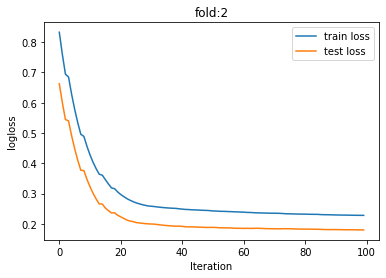

[I 2021-12-10 12:06:52,066] A new study created in memory with name: no-name-9b0b9cdb-1683-43b4-81a0-484bbed81ad7
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.106158:  14%|#4        | 1/7 [00:00<00:02,  2.87it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142166	Test's rmse: 0.106158
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.083282:  29%|##8       | 2/7 [00:00<00:01,  2.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13123	Test's rmse: 0.0832825
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.083282:  43%|####2     | 3/7 [00:01<00:01,  2.49it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137443	Test's rmse: 0.100619
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.021773:  57%|#####7    | 4/7 [00:01<00:01,  2.34it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.165773	Test's rmse: 0.0217725
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.021773:  71%|#######1  | 5/7 [00:02<00:00,  2.25it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12607	Test's rmse: 0.0474248
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.021773:  86%|########5 | 6/7 [00:02<00:00,  2.19it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153403	Test's rmse: 0.0395883
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.021773: 100%|##########| 7/7 [00:03<00:00,  2.29it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132491	Test's rmse: 0.0663863


num_leaves, val_score: 0.021773:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.020671:   5%|5         | 1/20 [00:00<00:13,  1.44it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.16676	Test's rmse: 0.0206715
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.020671:  10%|#         | 2/20 [00:01<00:12,  1.39it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.168046	Test's rmse: 0.0226713
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.020671:  15%|#5        | 3/20 [00:02<00:17,  1.01s/it]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165298	Test's rmse: 0.0221044
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.020671:  20%|##        | 4/20 [00:03<00:13,  1.15it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.165788	Test's rmse: 0.0216049
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.020671:  25%|##5       | 5/20 [00:04<00:13,  1.11it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.164257	Test's rmse: 0.021771
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.020671:  30%|###       | 6/20 [00:05<00:14,  1.00s/it]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165307	Test's rmse: 0.0221469
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.020671:  35%|###5      | 7/20 [00:06<00:10,  1.23it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.165436	Test's rmse: 0.0216517
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.020671:  40%|####      | 8/20 [00:07<00:11,  1.06it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.167385	Test's rmse: 0.0221384
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.020671:  45%|####5     | 9/20 [00:09<00:13,  1.20s/it]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165303	Test's rmse: 0.0221598
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.020671:  50%|#####     | 10/20 [00:09<00:10,  1.04s/it]

Early stopping, best iteration is:
[49]	Train's rmse: 0.164378	Test's rmse: 0.0213323
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.020671:  55%|#####5    | 11/20 [00:09<00:07,  1.24it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.168897	Test's rmse: 0.021353
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.020671:  60%|######    | 12/20 [00:10<00:06,  1.17it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.164232	Test's rmse: 0.0222021
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.020671:  65%|######5   | 13/20 [00:11<00:06,  1.12it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150385	Test's rmse: 0.0298034
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.020671:  70%|#######   | 14/20 [00:12<00:04,  1.23it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.164443	Test's rmse: 0.0211783
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.020671:  75%|#######5  | 15/20 [00:14<00:05,  1.04s/it]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165304	Test's rmse: 0.0221501
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.020671:  80%|########  | 16/20 [00:14<00:03,  1.21it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.16651	Test's rmse: 0.0212376
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.020671:  85%|########5 | 17/20 [00:15<00:02,  1.13it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.167386	Test's rmse: 0.0219515
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.020671:  90%|######### | 18/20 [00:16<00:01,  1.17it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.161377	Test's rmse: 0.0226101
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.020671:  95%|#########5| 19/20 [00:16<00:00,  1.31it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.164201	Test's rmse: 0.0214865
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.020671: 100%|##########| 20/20 [00:17<00:00,  1.14it/s]


Early stopping, best iteration is:
[42]	Train's rmse: 0.167402	Test's rmse: 0.0221366


bagging, val_score: 0.020671:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.020671:  10%|#         | 1/10 [00:00<00:07,  1.24it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.188481	Test's rmse: 0.0300041
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.020671:  20%|##        | 2/10 [00:01<00:06,  1.25it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16895	Test's rmse: 0.0246725
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.020671:  30%|###       | 3/10 [00:02<00:05,  1.25it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.176121	Test's rmse: 0.027096
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.020671:  40%|####      | 4/10 [00:03<00:04,  1.26it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.187949	Test's rmse: 0.0335859
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.020671:  50%|#####     | 5/10 [00:03<00:03,  1.27it/s]

Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.181922	Test's rmse: 0.0309006
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.020671:  60%|######    | 6/10 [00:04<00:03,  1.27it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.180437	Test's rmse: 0.0332078
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.020671:  70%|#######   | 7/10 [00:05<00:02,  1.28it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.183177	Test's rmse: 0.0284544
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.020671:  80%|########  | 8/10 [00:06<00:01,  1.29it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16429	Test's rmse: 0.0297936
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.020671:  90%|######### | 9/10 [00:07<00:00,  1.31it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.189543	Test's rmse: 0.0302375
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.020671: 100%|##########| 10/10 [00:07<00:00,  1.29it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.178143	Test's rmse: 0.0311505


feature_fraction_stage2, val_score: 0.020671:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.020671:  33%|###3      | 1/3 [00:00<00:01,  1.38it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146033	Test's rmse: 0.0409139
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.020671:  67%|######6   | 2/3 [00:01<00:00,  1.37it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147243	Test's rmse: 0.040304
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.020671: 100%|##########| 3/3 [00:02<00:00,  1.35it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147243	Test's rmse: 0.040304


regularization_factors, val_score: 0.020671:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.020671:   5%|5         | 1/20 [00:00<00:06,  2.88it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142808	Test's rmse: 0.0299152
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.020671:  10%|#         | 2/20 [00:01<00:10,  1.75it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.16676	Test's rmse: 0.0206715
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.020671:  15%|#5        | 3/20 [00:01<00:08,  2.07it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145279	Test's rmse: 0.0253794
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.020671:  20%|##        | 4/20 [00:02<00:09,  1.75it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.166759	Test's rmse: 0.0206723
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.020671:  25%|##5       | 5/20 [00:02<00:08,  1.68it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165055	Test's rmse: 0.0223058
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.020671:  30%|###       | 6/20 [00:03<00:08,  1.64it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.166382	Test's rmse: 0.021724
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.020671:  35%|###5      | 7/20 [00:03<00:07,  1.70it/s]

Early stopping, best iteration is:
[46]	Train's rmse: 0.165183	Test's rmse: 0.0211573
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.020671:  40%|####      | 8/20 [00:04<00:07,  1.65it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.166508	Test's rmse: 0.0218555
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.020671:  45%|####5     | 9/20 [00:05<00:06,  1.59it/s]

Early stopping, best iteration is:
[46]	Train's rmse: 0.164205	Test's rmse: 0.0209975
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.020371:  50%|#####     | 10/20 [00:05<00:05,  1.74it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.165889	Test's rmse: 0.0203707
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.020371:  55%|#####5    | 11/20 [00:06<00:05,  1.72it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153434	Test's rmse: 0.0253175
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.020371:  60%|######    | 12/20 [00:07<00:05,  1.59it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152835	Test's rmse: 0.0278099
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.020371:  65%|######5   | 13/20 [00:07<00:04,  1.55it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.16676	Test's rmse: 0.0206715
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.020371:  70%|#######   | 14/20 [00:08<00:03,  1.57it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155493	Test's rmse: 0.0271194
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.020371:  75%|#######5  | 15/20 [00:09<00:03,  1.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152139	Test's rmse: 0.027798
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.020371:  80%|########  | 16/20 [00:09<00:02,  1.64it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.16597	Test's rmse: 0.0207962
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.020163:  85%|########5 | 17/20 [00:10<00:01,  1.62it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.16619	Test's rmse: 0.0201633
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.020163:  90%|######### | 18/20 [00:10<00:01,  1.62it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.167317	Test's rmse: 0.0206553
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.020163:  95%|#########5| 19/20 [00:11<00:00,  1.50it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152109	Test's rmse: 0.0277424
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.020163: 100%|##########| 20/20 [00:12<00:00,  1.64it/s]


Early stopping, best iteration is:
[43]	Train's rmse: 0.169986	Test's rmse: 0.0207355


min_data_in_leaf, val_score: 0.020163:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.020163:  20%|##        | 1/5 [00:00<00:02,  1.77it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.125299	Test's rmse: 0.0244534
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.020163:  40%|####      | 2/5 [00:01<00:01,  1.72it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.257474	Test's rmse: 0.055551
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.020163:  60%|######    | 3/5 [00:01<00:01,  1.85it/s]

Early stopping, best iteration is:
[29]	Train's rmse: 0.318797	Test's rmse: 0.0894893
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.020163:  80%|########  | 4/5 [00:02<00:00,  1.88it/s]

Early stopping, best iteration is:
[38]	Train's rmse: 0.0681943	Test's rmse: 0.026991
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.020163: 100%|##########| 5/5 [00:02<00:00,  1.80it/s]

Early stopping, best iteration is:
[41]	Train's rmse: 0.176647	Test's rmse: 0.0273801


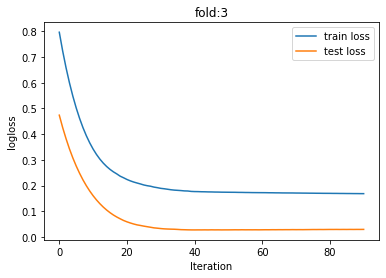

[I 2021-12-10 12:07:38,050] A new study created in memory with name: no-name-cd240220-0120-45a3-abe0-0e9ff9fbc488
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.388546:  14%|#4        | 1/7 [00:00<00:02,  2.06it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.15319	Test's rmse: 0.388546
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.373033:  29%|##8       | 2/7 [00:00<00:02,  2.13it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.15906	Test's rmse: 0.373033
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.373033:  43%|####2     | 3/7 [00:01<00:01,  2.25it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121666	Test's rmse: 0.413258
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.373033:  57%|#####7    | 4/7 [00:01<00:01,  2.26it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119068	Test's rmse: 0.407667
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.373033:  71%|#######1  | 5/7 [00:02<00:00,  2.18it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119956	Test's rmse: 0.397927
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.373033:  86%|########5 | 6/7 [00:02<00:00,  2.17it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.157903	Test's rmse: 0.380201
Training until validation scores don't improve for 50 rounds.


feature_fraction, val_score: 0.373033: 100%|##########| 7/7 [00:03<00:00,  2.20it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127532	Test's rmse: 0.411948


num_leaves, val_score: 0.373033:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.373033:   5%|5         | 1/20 [00:01<00:27,  1.46s/it]

Early stopping, best iteration is:
[32]	Train's rmse: 0.15918	Test's rmse: 0.376064
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.373033:  10%|#         | 2/20 [00:02<00:20,  1.13s/it]

Early stopping, best iteration is:
[32]	Train's rmse: 0.159187	Test's rmse: 0.376065
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.373033:  15%|#5        | 3/20 [00:02<00:14,  1.13it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.159209	Test's rmse: 0.376077
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.373033:  20%|##        | 4/20 [00:04<00:16,  1.00s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153042	Test's rmse: 0.375766
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.373033:  25%|##5       | 5/20 [00:05<00:17,  1.17s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153026	Test's rmse: 0.375768
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.373033:  30%|###       | 6/20 [00:07<00:17,  1.27s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153026	Test's rmse: 0.375768
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.373033:  35%|###5      | 7/20 [00:08<00:16,  1.24s/it]

Early stopping, best iteration is:
[32]	Train's rmse: 0.159185	Test's rmse: 0.376071
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.373033:  40%|####      | 8/20 [00:09<00:15,  1.31s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153026	Test's rmse: 0.375768
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.373033:  45%|####5     | 9/20 [00:10<00:14,  1.30s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153025	Test's rmse: 0.375781
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.373033:  50%|#####     | 10/20 [00:11<00:10,  1.05s/it]

Early stopping, best iteration is:
[31]	Train's rmse: 0.159648	Test's rmse: 0.37444
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.373033:  55%|#####5    | 11/20 [00:11<00:07,  1.21it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153318	Test's rmse: 0.375412
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.371375:  60%|######    | 12/20 [00:12<00:05,  1.50it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.158799	Test's rmse: 0.371375
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.348219:  65%|######5   | 13/20 [00:12<00:03,  1.88it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.166868	Test's rmse: 0.348219
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.348219:  70%|#######   | 14/20 [00:13<00:03,  1.61it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153035	Test's rmse: 0.375769
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.348219:  75%|#######5  | 15/20 [00:13<00:02,  2.01it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13478	Test's rmse: 0.364546
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.348219:  80%|########  | 16/20 [00:13<00:02,  1.85it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.159192	Test's rmse: 0.376069
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.348219:  85%|########5 | 17/20 [00:14<00:01,  2.20it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.155086	Test's rmse: 0.354284
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.348219:  90%|######### | 18/20 [00:15<00:01,  1.66it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.159186	Test's rmse: 0.376067
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.348219:  95%|#########5| 19/20 [00:15<00:00,  1.77it/s]

Early stopping, best iteration is:
[31]	Train's rmse: 0.15994	Test's rmse: 0.373707
Training until validation scores don't improve for 50 rounds.


num_leaves, val_score: 0.348219: 100%|##########| 20/20 [00:16<00:00,  1.22it/s]


Early stopping, best iteration is:
[32]	Train's rmse: 0.159223	Test's rmse: 0.376107


bagging, val_score: 0.348219:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.348219:  10%|#         | 1/10 [00:00<00:02,  3.51it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143698	Test's rmse: 0.360408
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.348219:  20%|##        | 2/10 [00:00<00:02,  3.73it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170589	Test's rmse: 0.359638
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.348219:  30%|###       | 3/10 [00:00<00:01,  3.67it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152879	Test's rmse: 0.352995
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.348219:  40%|####      | 4/10 [00:01<00:01,  3.49it/s][I 2021-12-10 12:07:58,776] Trial 30 finished with value: 0.3672120156099598 and parameters: {'bagging_fraction': 0.7486568085993955, 'bagging_freq': 4}. Best is trial 29 with value: 0.3529949371802952.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156707	Test's rmse: 0.367212


bagging, val_score: 0.348219:  40%|####      | 4/10 [00:01<00:01,  3.49it/s]

Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.348219:  50%|#####     | 5/10 [00:01<00:01,  3.60it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172864	Test's rmse: 0.349783
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.348219:  60%|######    | 6/10 [00:01<00:01,  3.73it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15739	Test's rmse: 0.356968
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.348219:  70%|#######   | 7/10 [00:01<00:00,  3.70it/s]

Did not meet early stopping. Best iteration is:
[91]	Train's rmse: 0.155474	Test's rmse: 0.35451
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.348219:  80%|########  | 8/10 [00:02<00:00,  3.67it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17246	Test's rmse: 0.349369
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.348219:  90%|######### | 9/10 [00:02<00:00,  3.73it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.159276	Test's rmse: 0.372255
Training until validation scores don't improve for 50 rounds.


bagging, val_score: 0.348219: 100%|##########| 10/10 [00:02<00:00,  3.67it/s]


Did not meet early stopping. Best iteration is:
[91]	Train's rmse: 0.160508	Test's rmse: 0.35653


feature_fraction_stage2, val_score: 0.348219:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.348219:  33%|###3      | 1/3 [00:00<00:00,  3.91it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.162345	Test's rmse: 0.349817
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.348219:  67%|######6   | 2/3 [00:00<00:00,  4.05it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132647	Test's rmse: 0.371633
Training until validation scores don't improve for 50 rounds.


feature_fraction_stage2, val_score: 0.348219: 100%|##########| 3/3 [00:00<00:00,  3.98it/s]


Early stopping, best iteration is:
[40]	Train's rmse: 0.162345	Test's rmse: 0.349817


regularization_factors, val_score: 0.348219:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.348219:   5%|5         | 1/20 [00:00<00:04,  4.18it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.161106	Test's rmse: 0.356257
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.348219:  10%|#         | 2/20 [00:00<00:04,  3.98it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.166869	Test's rmse: 0.348219
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.348219:  15%|#5        | 3/20 [00:00<00:04,  3.94it/s]

Early stopping, best iteration is:
[41]	Train's rmse: 0.173004	Test's rmse: 0.365915
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.348219:  20%|##        | 4/20 [00:01<00:03,  4.03it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.166869	Test's rmse: 0.348219
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.348219:  25%|##5       | 5/20 [00:01<00:03,  4.12it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.166871	Test's rmse: 0.348223
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.348219:  30%|###       | 6/20 [00:01<00:03,  4.06it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.166868	Test's rmse: 0.348219
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.348219:  35%|###5      | 7/20 [00:01<00:03,  4.11it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.161093	Test's rmse: 0.356245
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.348219:  40%|####      | 8/20 [00:01<00:02,  4.22it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.16687	Test's rmse: 0.348222
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.348219:  45%|####5     | 9/20 [00:02<00:02,  4.06it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.157625	Test's rmse: 0.35377
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.348219:  50%|#####     | 10/20 [00:02<00:02,  3.95it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139257	Test's rmse: 0.351539
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.348219:  55%|#####5    | 11/20 [00:02<00:02,  3.97it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.166868	Test's rmse: 0.348219
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.348219:  60%|######    | 12/20 [00:02<00:01,  4.06it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.166868	Test's rmse: 0.348219
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.348219:  65%|######5   | 13/20 [00:03<00:01,  4.03it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.166868	Test's rmse: 0.348219
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.348219:  70%|#######   | 14/20 [00:03<00:01,  4.00it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.166868	Test's rmse: 0.348219
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.348219:  75%|#######5  | 15/20 [00:03<00:01,  4.00it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.166868	Test's rmse: 0.348219
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.348219:  80%|########  | 16/20 [00:03<00:00,  4.06it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.166868	Test's rmse: 0.348219
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.348219:  85%|########5 | 17/20 [00:04<00:00,  4.13it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.166879	Test's rmse: 0.348237
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.348219:  90%|######### | 18/20 [00:04<00:00,  4.06it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.166875	Test's rmse: 0.348229
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.348219:  95%|#########5| 19/20 [00:04<00:00,  4.09it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.166868	Test's rmse: 0.348219
Training until validation scores don't improve for 50 rounds.


regularization_factors, val_score: 0.348219: 100%|##########| 20/20 [00:04<00:00,  4.05it/s]


Early stopping, best iteration is:
[36]	Train's rmse: 0.166868	Test's rmse: 0.348219


min_data_in_leaf, val_score: 0.348219:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.348219:  20%|##        | 1/5 [00:00<00:01,  3.71it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0876453	Test's rmse: 0.367547
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.348219:  40%|####      | 2/5 [00:00<00:00,  3.72it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15682	Test's rmse: 0.353293
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.348219:  60%|######    | 3/5 [00:00<00:00,  3.58it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0994145	Test's rmse: 0.348376
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.348219:  80%|########  | 4/5 [00:01<00:00,  3.63it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.239649	Test's rmse: 0.479195
Training until validation scores don't improve for 50 rounds.


min_data_in_leaf, val_score: 0.348219: 100%|##########| 5/5 [00:01<00:00,  3.63it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.202534	Test's rmse: 0.433994


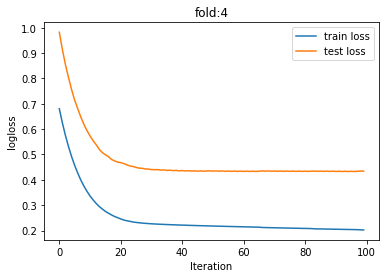

RMSE: [0.32383696438327747, 0.10121648967309672, 0.13795974258660068, 0.020163299121346307, 0.3482186449932157]
RMSE: 0.18627902815150738


In [ ]:
start_opt = time.time()

y_train = y_train.reset_index(drop=True)

gkf = GroupKFold(n_splits=5)

groups = X_train_ce["Genre"]

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

best_params, history = {}, []

cv_result_opt = []

for fold, (train_index, test_index) in enumerate(gkf.split(X_train_ce, y_train, groups)):
    X_train_gkf, X_test_gkf = X_train_ce.iloc[train_index], X_train_ce.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    # 学習、推論
    lgb_train = opt_lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = opt_lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = opt_lgb.train(
                    params,                    # ハイパーパラメータをセット
                    lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    )  
    
    best_params = model.params

    # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = model.predict(X_test_gkf, num_iteration=model.best_iteration)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_opt.append(rmse)

print("RMSE:", cv_result_opt)
print("RMSE:", np.mean(cv_result_opt))

elasp_time_opt = round((time.time() - start_opt), 1)

## ベイズ最適化

In [ ]:
start_bayes = time.time()

In [ ]:
def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
    params = {
        'application':'regression',
        'num_iterations':4000, 
        'learning_rate':0.05, 
        'early_stopping_round':100, 
        'metric':'rmse'
        }

    params["num_leaves"] = round(num_leaves)
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = round(max_depth)
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight

    cv_result = lgb.cv(
        params, 
        train_data,
        nfold=n_folds, 
        seed=random_seed, 
        stratified=False, 
        verbose_eval =200, 
        metrics=['rmse']
        )
    
    return max(cv_result['rmse-mean'])

In [ ]:
lgbBO = BayesianOptimization(
                        lgb_eval, 
                        {
                            'num_leaves': (24, 45),
                            'feature_fraction': (0.1, 0.9),
                            'bagging_fraction': (0.8, 1),
                            'max_depth': (5, 8.99),
                            'lambda_l1': (0, 5),
                            'lambda_l2': (0, 3),
                            'min_split_gain': (0.001, 0.1),
                            'min_child_weight': (5, 50)
                            }, 
                        random_state=SEED
)

In [ ]:
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.05, output_process=False):
    
    # prepare data
    train_data = lgb.Dataset(
                            data=X_train_ce,  ### 適宜要修正
                            label=y_train,   ### 適宜要修正
                            free_raw_data=False
                            )

    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        
        params = {
            'application':'regression',
            'num_iterations': n_estimators, 
            'learning_rate':learning_rate, 
            'early_stopping_round':100, 
            'metric':'rmse'
            }

        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight

        cv_result = lgb.cv(
            params, train_data, 
            nfold=n_folds, 
            seed=random_seed, 
            stratified=False, 
            verbose_eval =200, 
            metrics=['rmse']
            )
        
        return max(cv_result['rmse-mean'])

    lgbBO = BayesianOptimization(lgb_eval, 
                                            {'num_leaves': (24, 45),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 8.99),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 50)}, random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO.res[0]["params"]

In [ ]:
opt_params = bayes_parameter_opt_lgb(
                                    X_train_ce, 
                                    y_train, 
                                    init_round=5, 
                                    opt_round=10, 
                                    n_folds=3, 
                                    random_seed=SEED, 
                                    n_estimators=100, 
                                    learning_rate=0.05
                                    )

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7795   |  0.9098   |  0.6722   |  3.014    |  1.635    |  6.69     |  34.07    |  0.04432  |  42.73    |
|  2        |  0.7803   |  0.9927   |  0.4068   |  3.959    |  1.587    |  7.266    |  46.65    |  0.008033 |  25.83    |
|  3        |  0.7807   |  0.804    |  0.7661   |  3.891    |  2.61     |  8.905    |  40.96    |  0.04669  |  40.39    |
|  4        |  0.7793   |  0.8237   |  0.6119   |  0.7168   |  2.834    |  7.082    |  23.66    |  0.02719  |  40.26    |
|  5        |  0.7786   |  0.8912   |  0.5547   |  0.09395  |  1.853    |  7.442    |  32.76    |  0.09443  |  38.32    |
|  6        |  0.7802   |  0.8647   |  0.5032   |  4.33     |  1.08     |  8.168    |  43.55    |  0.07678  |  40.34    |
|  7        |  0.7808   

In [ ]:
print(opt_params)

{'bagging_fraction': 0.909762700785465, 'feature_fraction': 0.6721514930979355, 'lambda_l1': 3.0138168803582195, 'lambda_l2': 1.6346495489906907, 'max_depth': 6.690382649362229, 'min_child_weight': 34.065235087999525, 'min_split_gain': 0.04432113391500656, 'num_leaves': 42.727233016423675}


## ベストパラメータで学習・推論

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152566	Test's rmse: 0.337686


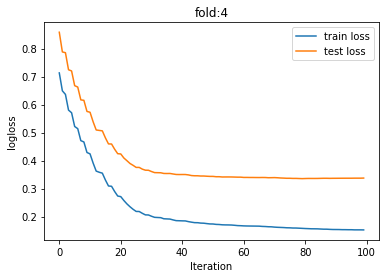

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.180357	Test's rmse: 0.115844


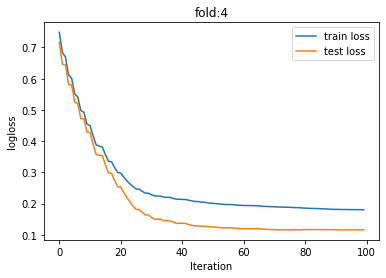

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170579	Test's rmse: 0.156687


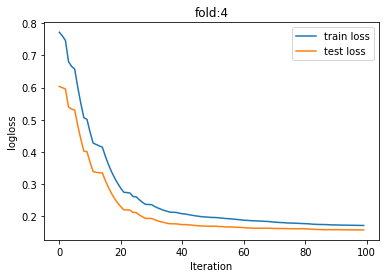

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173589	Test's rmse: 0.0693091


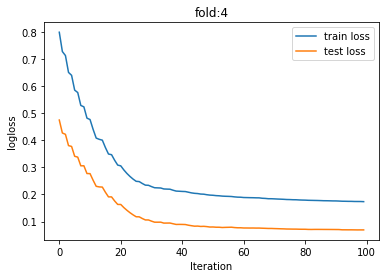

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168029	Test's rmse: 0.363027


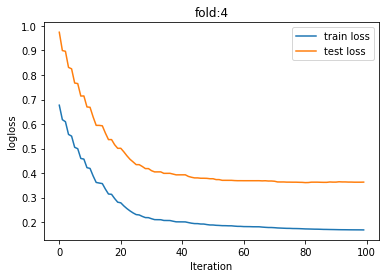

RMSE: [0.33768567412974154, 0.1158439742432352, 0.15668746448451032, 0.06930909394305391, 0.36302734001199854]
RMSE: 0.2085107093625079


In [ ]:
y_train = y_train.reset_index(drop=True)

gkf = GroupKFold(n_splits=5)

groups = X_train_ce["Genre"]

lgb_results = {}                                    # 学習の履歴を入れる入物

opt_params["application"] = "regression" # 回帰を追加
opt_params["metrics"] = "rmse" # 評価指標を追加
opt_params["num_leaves"] = int(round(opt_params["num_leaves"])) # 整数に変換
opt_params["max_depth"] = int(round(opt_params["max_depth"])) # 整数に変換

cv_result_bayes = []

for train_index, test_index in gkf.split(X_train_ce, y_train, groups):
    X_train_gkf, X_test_gkf = X_train_ce.iloc[train_index], X_train_ce.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    # データセットを登録
    lgb_train = lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = lgb.train(
                    params=opt_params,           # ベストパラメータをセット
                    train_set=lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                           # ログを最後の1つだけ表示
                    )
    
    # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = model.predict(X_test_gkf)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_bayes.append(rmse)

print("RMSE:", cv_result_bayes)
print("RMSE:", np.mean(cv_result_bayes))

elasp_time_bayes = round((time.time() - start_bayes), 1)

In [ ]:
print("Optuna RMSE:", round(np.mean(cv_result_opt), 3), "経過時間:", elasp_time_opt, "秒")
print("ベイズ最適化 RMSE:", round(np.mean(cv_result_bayes), 3), "経過時間:", elasp_time_bayes, "秒")

Optuna RMSE: 0.186 経過時間: 187.2 秒
ベイズ最適化 RMSE: 0.209 経過時間: 13.9 秒
